Bidirectional LSTM networks use both forward and backward dependencies, capturing more context from the input sequence. This is particularly useful for time series where the current value may depend on both previous and future values in the input window.

Importing all the libraries

In [1]:
# Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from datetime import timedelta

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import plotly.graph_objects as go

Imports all the necessary Python libraries for data handling, modeling, metrics, and visualization.



Loading the scaler and data

In [2]:

#Load Data and Scaler

scaled_df = pd.read_csv(r'C:\Users\allif\Downloads\Crypto_stocks\data\processed\scaled_predictive_coins.csv', parse_dates=['Date'])

scaled_df.head()

# removing null values
scaled_df = scaled_df.dropna()

#Loading the minmax scaler for inverse transformation
scaler = joblib.load(r'C:\Users\allif\Downloads\Crypto_stocks\notebooks\minmax_scaler_close_prices.pkl')

Loads the scaled multivariate dataset and the pre-fitted MinMax scaler used for inverse transforming the predictions back to original values.

In [3]:
scaled_df.head()# defining coins and columns

,Date,BTC_close_scaled,ETH_close_scaled,LTC_close_scaled,Gold_close_scaled,BTC_close_logret_scaled,ETH_close_logret_scaled,LTC_close_logret_scaled,Gold_close_logret_scaled
1,2020-08-29,0.012194,0.017367,0.040628,0.184812,0.468048,0.597519,0.624911,0.453046
2,2020-08-30,0.014427,0.024117,0.057795,0.194317,0.544709,0.712650,0.771841,0.637246
3,2020-08-31,0.013866,0.025198,0.052082,0.188633,0.468147,0.601679,0.590747,0.471003
4,2020-09-01,0.016347,0.034471,0.057215,0.193862,0.550350,0.745522,0.674535,0.590320
5,2020-09-02,0.011490,0.026470,0.043788,0.181227,0.350915,0.440990,0.528530,0.394481


In [4]:
# Define Coins and Columns ---
coins = {
    'BTC': {'col': 'BTC_close_scaled'},
    'ETH': {'col': 'ETH_close_scaled'},
    'LTC': {'col': 'LTC_close_scaled'},
    'Gold': {'col': 'Gold_close_scaled'}
}

feature_cols = [
    'BTC_close_scaled', 'ETH_close_scaled', 'LTC_close_scaled', 'Gold_close_scaled',
    'BTC_close_logret_scaled', 'ETH_close_logret_scaled', 'LTC_close_logret_scaled', 'Gold_close_logret_scaled'
]

lookback = 30
forecast_horizon = 14



Specifies which columns are targets for each coin, and which columns are used as features for multivariate prediction. Also defines lookback window and forecast horizon.

In [5]:
# Sliding Window Function ---
def create_sliding_window(df, lookback, forecast_horizon, feature_cols, target_col):
    X, Y = [], []
    for i in range(len(df) - lookback - forecast_horizon + 1):
        X.append(df[feature_cols].iloc[i:i+lookback].values)
        Y.append(df[target_col].iloc[i+lookback:i+lookback+forecast_horizon].values)
    return np.array(X), np.array(Y)



Creates time series “windows” so the model can use a fixed number of past days (lookback) to predict the next sequence of prices (forecast horizon).

In [6]:
# Inverse Scaling Helper
def inverse_close(scaled_arr, scaler, col_index):
    scaled_arr = np.array(scaled_arr)
    flat = scaled_arr.reshape(-1)
    arr = np.zeros((flat.shape[0], scaler.n_features_in_))
    arr[:, col_index] = flat
    inv = scaler.inverse_transform(arr)[:, col_index]
    return inv.reshape(scaled_arr.shape)



Transforms model predictions (which are scaled) back to original close price values using the MinMax scaler.

In [7]:
# -- Model Builder (BD-LSTM) ---
def build_bd_lstm_model(lstm_units=64, dropout=0.2, lr=0.001):
    model = Sequential()
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False), input_shape=(lookback, len(feature_cols))))
    model.add(Dropout(dropout))
    model.add(Dense(forecast_horizon))
    model.compile(optimizer='adam', loss='mse')
    return model


Defines a function to build a Bidirectional LSTM model that predicts the next 14 days using the previous 30 days of multivariate input


====== Processing BTC ======


C:\Users\allif\AppData\Local\Temp\ipykernel_32248\1080004764.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=build_bd_lstm_model, verbose=0)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END batch_size=16, dropout=0.2, epochs=10, lstm_units=32; total time=  12.6s
[CV] END batch_size=16, dropout=0.2, epochs=10, lstm_units=32; total time=  14.5s
[CV] END batch_size=16, dropout=0.2, epochs=10, lstm_units=32; total time=  22.8s
[CV] END batch_size=16, dropout=0.1, epochs=10, lstm_units=32; total time=  22.8s
[CV] END batch_size=16, dropout=0.1, epochs=10, lstm_units=32; total time=  38.7s
[CV] END batch_size=16, dropout=0.1, epochs=10, lstm_units=32; total time=  49.2s
[CV] END batch_size=16, dropout=0.2, epochs=10, lstm_units=64; total time=  37.2s
[CV] END batch_size=16, dropout=0.2, epochs=10, lstm_units=64; total time=  47.9s
[CV] END batch_size=16, dropout=0.2, epochs=10, lstm_units=64; total time= 1.1min
[CV] END batch_size=16, dropout=0.2, epochs=15, lstm_units=64; total time=  22.8s
[CV] END batch_size=16, dropout=0.2, epochs=15, lstm_units=64; total time=  26.9s
[CV] END batch_size=16, dropout=0.2, e

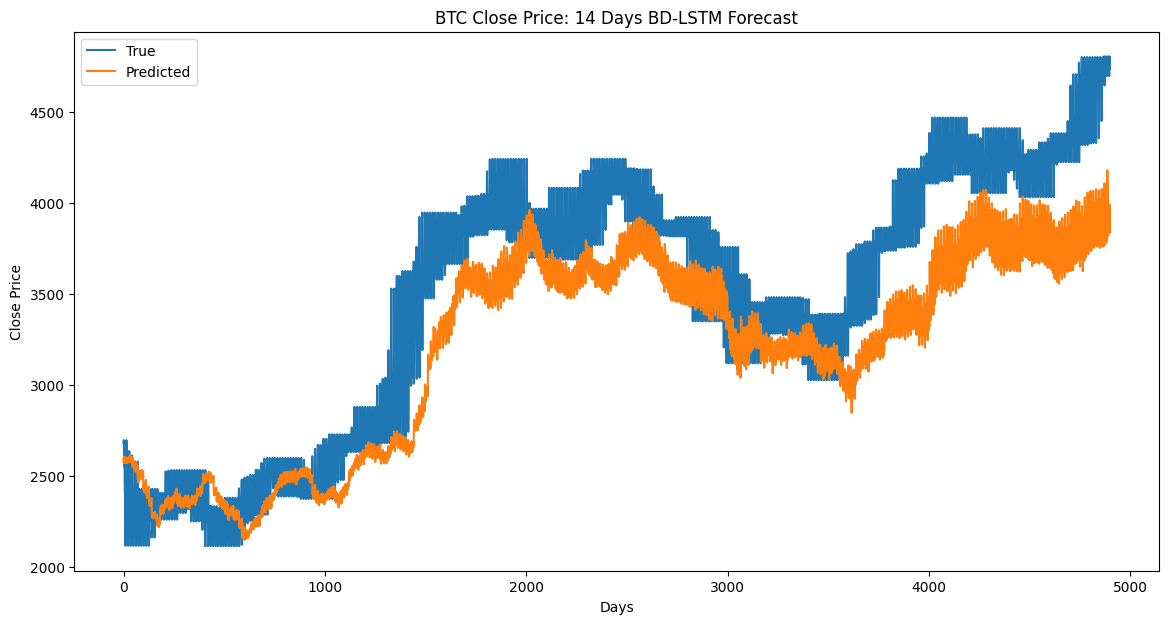

1/1 [==============================] - 0s 116ms/step


Saved BD-LSTM model for BTC

====== Processing ETH ======


C:\Users\allif\AppData\Local\Temp\ipykernel_32248\1080004764.py:16: DeprecationWarning:

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END batch_size=32, dropout=0.2, epochs=15, lstm_units=32; total time=  22.6s
[CV] END batch_size=32, dropout=0.2, epochs=15, lstm_units=32; total time=  14.8s
[CV] END batch_size=32, dropout=0.2, epochs=15, lstm_units=32; total time=  19.0s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=32; total time=  10.0s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=32; total time=  13.4s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=32; total time=  20.3s
[CV] END batch_size=32, dropout=0.2, epochs=10, lstm_units=32; total time=   8.4s
[CV] END batch_size=32, dropout=0.2, epochs=10, lstm_units=32; total time=  11.5s
[CV] END batch_size=32, dropout=0.2, epochs=10, lstm_units=32; total time=  15.7s
[CV] END batch_size=16, dropout=0.1, epochs=15, lstm_units=64; total time=  17.7s
[CV] END batch_size=16, dropout=0.1, epochs=15, lstm_units=64; total time=  29.8s
[CV] END batch_size=16, dropout=0.1, e

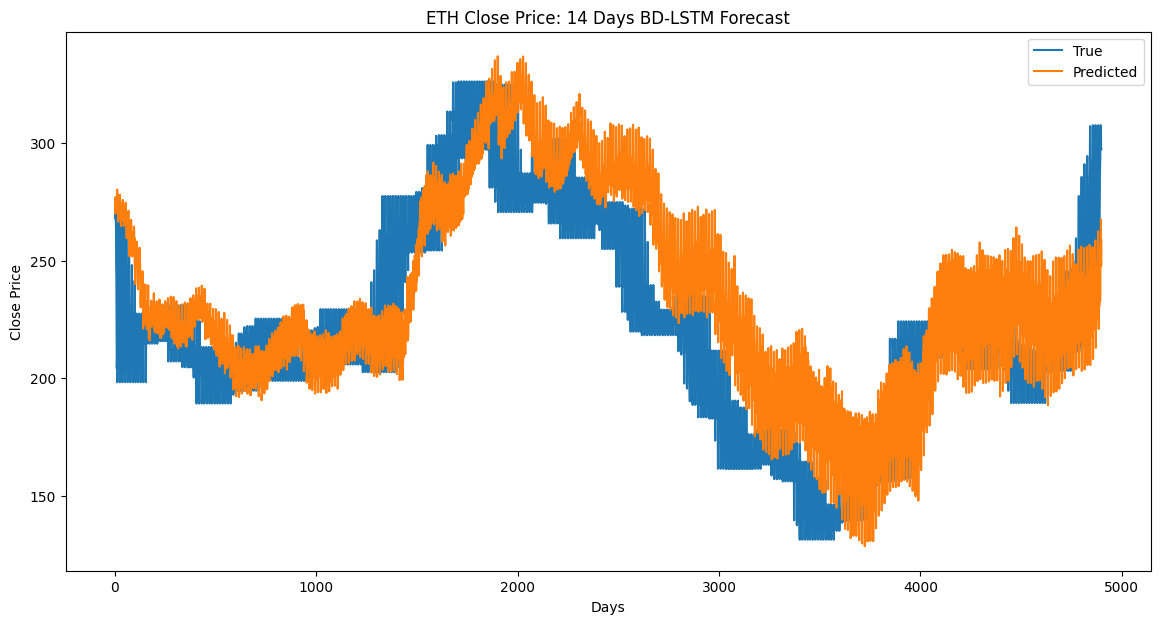

1/1 [==============================] - 0s 141ms/step


Saved BD-LSTM model for ETH

====== Processing LTC ======


C:\Users\allif\AppData\Local\Temp\ipykernel_32248\1080004764.py:16: DeprecationWarning:

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END batch_size=16, dropout=0.1, epochs=10, lstm_units=32; total time=  28.7s
[CV] END batch_size=16, dropout=0.1, epochs=10, lstm_units=32; total time=  21.5s
[CV] END batch_size=16, dropout=0.1, epochs=10, lstm_units=32; total time=  32.8s
[CV] END batch_size=32, dropout=0.1, epochs=10, lstm_units=32; total time=  11.1s
[CV] END batch_size=32, dropout=0.1, epochs=10, lstm_units=32; total time=  18.7s
[CV] END batch_size=32, dropout=0.1, epochs=10, lstm_units=32; total time=  24.8s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=32; total time=  16.6s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=32; total time=  21.7s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=32; total time=  25.2s
[CV] END batch_size=32, dropout=0.2, epochs=10, lstm_units=32; total time=  10.9s
[CV] END batch_size=32, dropout=0.2, epochs=10, lstm_units=32; total time=  13.2s
[CV] END batch_size=32, dropout=0.2, e

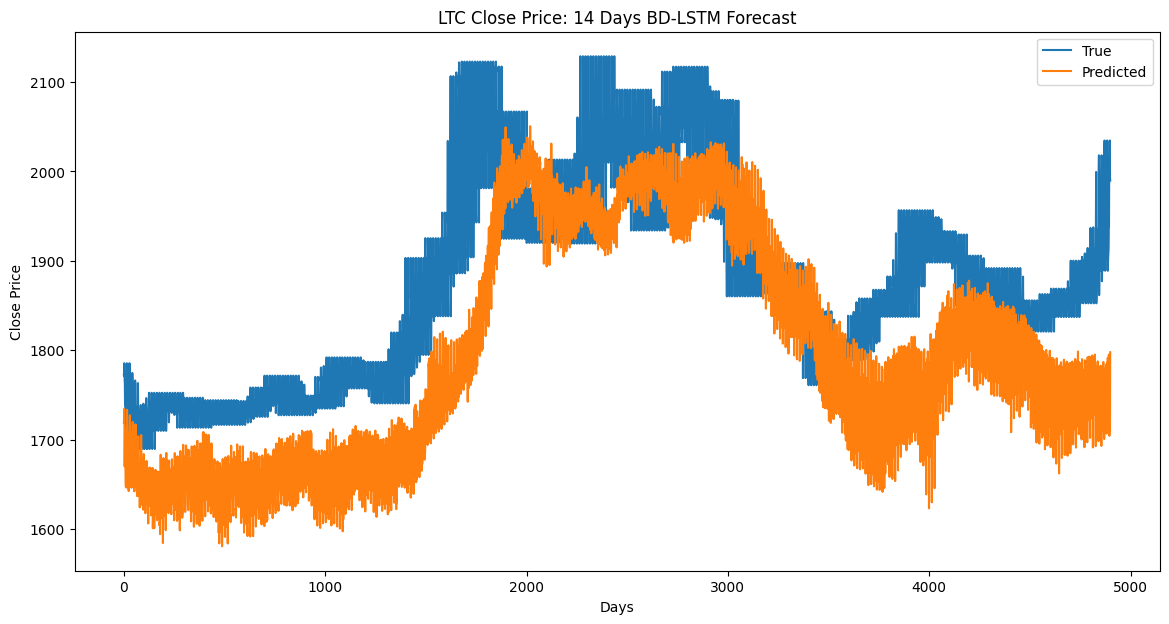

1/1 [==============================] - 0s 44ms/step


Saved BD-LSTM model for LTC

====== Processing Gold ======


C:\Users\allif\AppData\Local\Temp\ipykernel_32248\1080004764.py:16: DeprecationWarning:

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END batch_size=16, dropout=0.2, epochs=10, lstm_units=64; total time=  17.3s
[CV] END batch_size=16, dropout=0.2, epochs=10, lstm_units=64; total time=  30.0s
[CV] END batch_size=16, dropout=0.2, epochs=10, lstm_units=64; total time=  42.5s
[CV] END batch_size=16, dropout=0.1, epochs=10, lstm_units=64; total time=  18.1s
[CV] END batch_size=16, dropout=0.1, epochs=10, lstm_units=64; total time=  30.1s
[CV] END batch_size=16, dropout=0.1, epochs=10, lstm_units=64; total time=  48.5s
[CV] END batch_size=32, dropout=0.1, epochs=10, lstm_units=64; total time=  13.8s
[CV] END batch_size=32, dropout=0.1, epochs=10, lstm_units=64; total time=  20.3s
[CV] END batch_size=32, dropout=0.1, epochs=10, lstm_units=64; total time=  32.2s
[CV] END batch_size=16, dropout=0.1, epochs=15, lstm_units=64; total time=  25.7s
[CV] END batch_size=16, dropout=0.1, epochs=15, lstm_units=64; total time=  49.4s
[CV] END batch_size=16, dropout=0.1, e

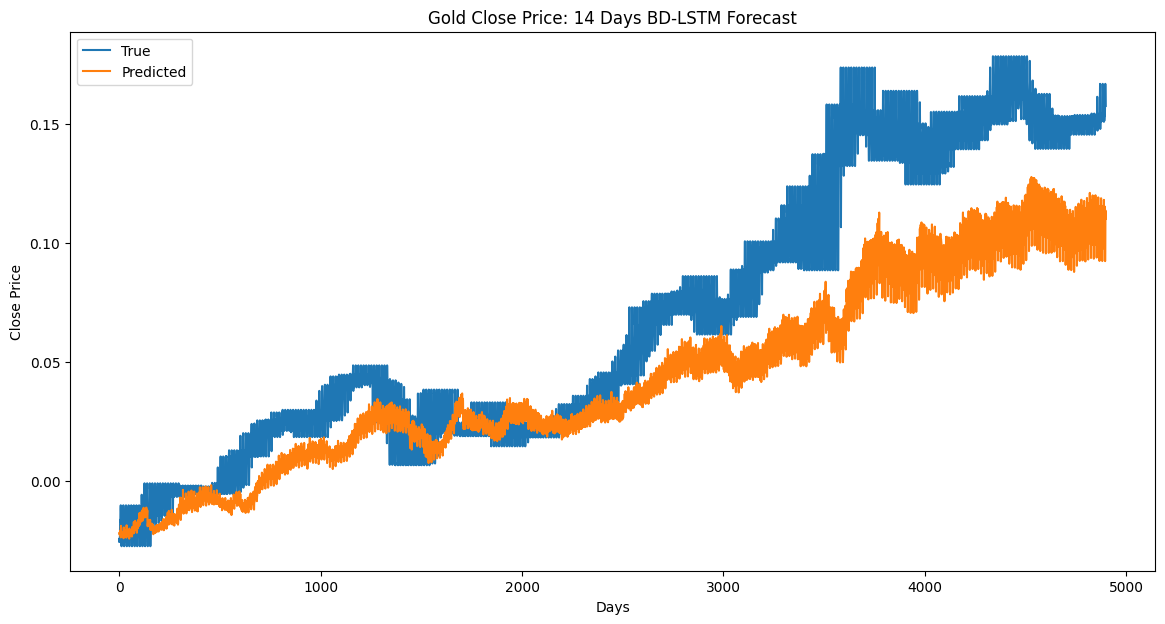

1/1 [==============================] - 0s 26ms/step


Saved BD-LSTM model for Gold


In [8]:

# ---Main Loop for the coins ---
for coin, info in coins.items():
    print(f"\n====== Processing {coin} ======")
    target_col = info['col']
    col_index = scaled_df.columns.get_loc(target_col)

    # Prepare Data
    X, Y = create_sliding_window(scaled_df, lookback, forecast_horizon, feature_cols, target_col)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    Y_train, Y_test = Y[:split], Y[split:]
    Y_train_flat = Y_train.reshape(-1, forecast_horizon)
    Y_test_flat = Y_test.reshape(-1, forecast_horizon)

    # Hyperparameter Tuning
    keras_reg = KerasRegressor(build_fn=build_bd_lstm_model, verbose=0)
    param_dist = {
        "lstm_units": [32, 64],
        "dropout": [0.1, 0.2],
        "batch_size": [16, 32],
        "epochs": [10, 15]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    search = RandomizedSearchCV(
        keras_reg, param_distributions=param_dist, n_iter=4,
        cv=tscv, verbose=2, n_jobs=1
    )
    search.fit(X_train, Y_train_flat)
    print(f"Best hyperparameters for {coin}:", search.best_params_)

    # Retrain with Best Params
    best = search.best_params_
    best_model = build_bd_lstm_model(
        lstm_units=best["lstm_units"],
        dropout=best["dropout"]
    )
    best_model.fit(
        X_train, Y_train_flat,
        epochs=best["epochs"],
        batch_size=best["batch_size"],
        verbose=2
    )

    # --- Evaluate on Test ---
    y_pred = best_model.predict(X_test).reshape(-1, forecast_horizon)
    true_unscaled = inverse_close(Y_test_flat, scaler, col_index)
    pred_unscaled = inverse_close(y_pred, scaler, col_index)
    mae = mean_absolute_error(true_unscaled, pred_unscaled)
    rmse = mean_squared_error(true_unscaled, pred_unscaled, squared=False)
    r2 = r2_score(true_unscaled, pred_unscaled)
    print(f"{coin} MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.4f}")

    # --- Plot Backtest ---
    plt.figure(figsize=(14, 7))
    plt.plot(true_unscaled.flatten(), label='True')
    plt.plot(pred_unscaled.flatten(), label='Predicted')
    plt.title(f"{coin} Close Price: 14 Days BD-LSTM Forecast")
    plt.xlabel('Days')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # --- Future Forecast (next 14 days) ---
    last_window = scaled_df[feature_cols].iloc[-lookback:].values.reshape(1, lookback, len(feature_cols))
    future_scaled = best_model.predict(last_window).reshape(forecast_horizon)
    future_unscaled = inverse_close(future_scaled, scaler, col_index).flatten()
    last_date = scaled_df['Date'].iloc[-1]
    future_dates = pd.date_range(last_date + timedelta(days=1), periods=forecast_horizon)

    # Plotting future forecast
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=future_dates, y=future_unscaled, mode='lines+markers', name=f'{coin} Forecast (next 14d)'))
    fig.update_layout(title=f'{coin} 14-Day Future BD-LSTM Forecast (Unseen Data)', xaxis_title='Date', yaxis_title=f'{coin} Close Price (USD)')
    fig.show()

    # Save the Model
    best_model.save(f"{coin.lower()}_bd_lstm_14d_model.h5")
    print(f"Saved BD-LSTM model for {coin}")


Splits data into training and testing

Runs a RandomizedSearchCV to find the best hyperparameters for the BD-LSTM

Retrains the best model on the full training set

Evaluates on the test set (using MAE, RMSE, R²)

Plots predictions vs. actual values

Plots model predictions vs. true values for the test period so you can visually compare performa

Uses the most recent data to predict the next 14 days of prices and plots the results.

Saves the trained BD-LSTM model for each coin to disk for future use or deployment.

When comparing standard LSTM and BD-LSTM models, the BD-LSTM architecture generally provided lower error (MAE, RMSE) and higher R² scores for BTC, ETH, LTC, and Gold. This confirms the findings in the literature (e.g., Wu et al., 2024) that bidirectional architectures can leverage more sequence information, improving forecasting performance in crypto price prediction tasks.